# Decision Tree Regression

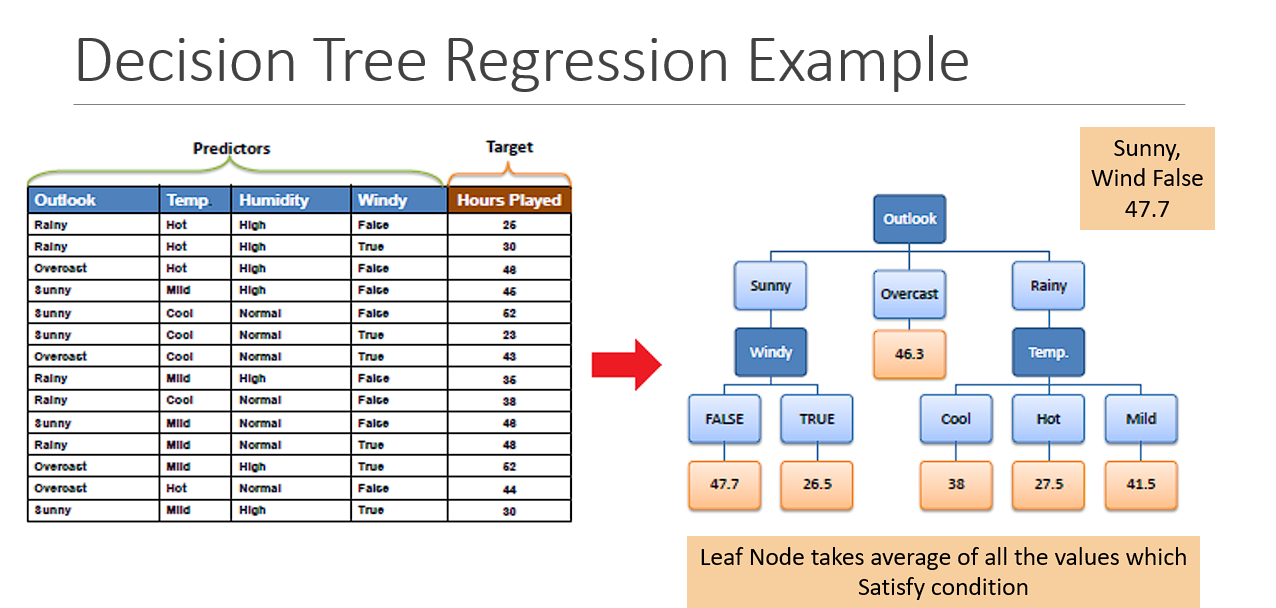

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

# Step 1: Read the dataset

In [2]:
import pandas as pd
df = pd.read_csv('50_Startups.csv')
df.head()

,RND,ADMIN,MKT,STATE,PROFIT
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


## PROFIT is target feature

### Step 2: Perform the basic data quality checks

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RND     50 non-null     float64
 1   ADMIN   50 non-null     float64
 2   MKT     50 non-null     float64
 3   STATE   50 non-null     object 
 4   PROFIT  50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [4]:
df.isna().sum()

RND       0
ADMIN     0
MKT       0
STATE     0
PROFIT    0
dtype: int64

In [5]:
df.duplicated().sum()

0

### Step 3: Seperate X and Y

In [6]:
X = df.drop(columns=['PROFIT'])
Y = df[['PROFIT']]

In [7]:
X.head()

,RND,ADMIN,MKT,STATE
0,165349.20,136897.80,471784.10,New York
1,162597.70,151377.59,443898.53,California
2,153441.51,101145.55,407934.54,Florida
3,144372.41,118671.85,383199.62,New York
4,142107.34,91391.77,366168.42,Florida


In [8]:
Y.head()

,PROFIT
0,192261.83
1,191792.06
2,191050.39
3,182901.99
4,166187.94


### Step 4: Create a preprocessing pipeline for X

In [9]:
cat = list(X.columns[X.dtypes=='object'])
con = list(X.columns[X.dtypes!='object'])

In [10]:
cat

['STATE']

In [11]:
con

['RND', 'ADMIN', 'MKT']

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [13]:
num_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='mean')),
                           ('scaler', StandardScaler())])

In [14]:
cat_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                           ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [15]:
pre = ColumnTransformer([('con', num_pipe, con),
                         ('cat', cat_pipe, cat)]).set_output(transform='pandas')

In [16]:
pre

ColumnTransformer(transformers=[('con',
                                 Pipeline(steps=[('impute', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['RND', 'ADMIN', 'MKT']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['STATE'])])

In [17]:
X_pre = pre.fit_transform(X)
X_pre.head()

,con__RND,con__ADMIN,con__MKT,cat__STATE_California,cat__STATE_Florida,cat__STATE_New York
0,2.016411,0.560753,2.153943,0.0,0.0,1.0
1,1.955860,1.082807,1.923600,1.0,0.0,0.0
2,1.754364,-0.728257,1.626528,0.0,1.0,0.0
3,1.554784,-0.096365,1.422210,0.0,0.0,1.0
4,1.504937,-1.079919,1.281528,0.0,1.0,0.0


### Step 5: Perform train test split

In [18]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_pre, Y, test_size=0.2, random_state=21)

In [19]:
xtrain.shape

(40, 6)

In [20]:
xtest.shape

(10, 6)

In [21]:
xtrain.head()

,con__RND,con__ADMIN,con__MKT,cat__STATE_California,cat__STATE_Florida,cat__STATE_New York
30,-0.258074,-0.205629,-0.990357,0.0,1.0,0.0
21,0.102724,1.169186,0.732788,0.0,0.0,1.0
19,0.279442,1.159837,-1.743127,0.0,0.0,1.0
11,0.593085,-1.065540,0.319834,1.0,0.0,0.0
22,0.006007,0.051850,0.762376,0.0,1.0,0.0


In [22]:
ytrain.head()

,PROFIT
30,99937.59
21,111313.02
19,122776.86
11,144259.40
22,110352.25


In [23]:
xtest.head()

,con__RND,con__ADMIN,con__MKT,cat__STATE_California,cat__STATE_Florida,cat__STATE_New York
7,1.245057,0.871980,0.932186,0.0,1.0,0.0
44,-1.134305,1.206419,-1.509074,1.0,0.0,0.0
43,-1.281134,0.217682,-1.449605,0.0,0.0,1.0
25,-0.199312,0.656489,-0.603517,1.0,0.0,0.0
14,1.017181,1.269199,0.375742,0.0,1.0,0.0


In [24]:
ytest.head()

,PROFIT
7,155752.60
44,65200.33
43,69758.98
25,107404.34
14,132602.65


### Step 6: Build a decision tree regression model

In [25]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=1, min_samples_split=5, min_samples_leaf=5, criterion='absolute_error')
model.fit(xtrain, ytrain)

DecisionTreeRegressor(criterion='absolute_error', max_depth=1,
                      min_samples_leaf=5, min_samples_split=5)

In [26]:
# Check r2 score in train
model.score(xtrain, ytrain)

0.6019636534994364

In [27]:
# Check r2 score in test
model.score(xtest, ytest)

0.5746278420052591

### Step 7: Hyperparemeter tuning

In [28]:
params = {'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10],
          'min_samples_split':[3, 4, 5, 6, 7, 8],
          'min_samples_leaf':[3, 4, 5, 6, 7, 8],
          'criterion':['squared_error', 'absolute_error']}

In [29]:
from sklearn.model_selection import GridSearchCV
dtr = DecisionTreeRegressor()
gscv = GridSearchCV(dtr, param_grid=params, cv=5, scoring='neg_mean_squared_error')
gscv.fit(xtrain, ytrain)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [3, 4, 5, 6, 7, 8],
                         'min_samples_split': [3, 4, 5, 6, 7, 8]},
             scoring='neg_mean_squared_error')

In [30]:
gscv.best_params_

{'criterion': 'absolute_error',
 'max_depth': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 5}

In [34]:
type(gscv.best_params_)

dict

In [31]:
gscv.best_score_

-286977329.94868994

In [32]:
best_dtr = gscv.best_estimator_
best_dtr

DecisionTreeRegressor(criterion='absolute_error', max_depth=4,
                      min_samples_leaf=3, min_samples_split=5)

In [35]:
type(gscv.best_estimator_)

sklearn.tree._classes.DecisionTreeRegressor

### Step 8: Evaluate tuned model

In [36]:
# r2 score for training
best_dtr.score(xtrain, ytrain)

0.964491148172637

In [37]:
# r2 score for testing
best_dtr.score(xtest, ytest)

0.9397388817493316

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def evaluate_model(model, x, y):
    ypred = model.predict(x)
    mse = mean_squared_error(y, ypred)
    rmse = mse**(1/2)
    mae = mean_absolute_error(y, ypred)
    r2 = r2_score(y, ypred)
    print(f'Mean Squared Error : {mse:.2f}')
    print(f'Root Mean Squared Error : {rmse:.2f}')
    print(f'Mean Absolute Error : {mae:.2f}')
    print(f'R2 Score : {r2:.4f}')

In [40]:
evaluate_model(best_dtr, xtrain, ytrain)

Mean Squared Error : 54847052.08
Root Mean Squared Error : 7405.88
Mean Absolute Error : 4473.23
R2 Score : 0.9645


In [41]:
evaluate_model(best_dtr, xtest, ytest)

Mean Squared Error : 106948230.95
Root Mean Squared Error : 10341.58
Mean Absolute Error : 6877.47
R2 Score : 0.9397


In [44]:
from sklearn.model_selection import cross_val_score
scores_r2 = cross_val_score(best_dtr, xtrain, ytrain, cv=3, scoring='r2')
scores_r2

array([0.70226187, 0.83205385, 0.74934227])

In [45]:
scores_r2.mean()

0.7612193265782811

### Predict train and test results

In [46]:
ypred_train = best_dtr.predict(xtrain)
ypred_test = best_dtr.predict(xtest)

In [47]:
ypred_train[0:5]

array([ 96778.92, 111313.02, 111313.02, 141585.52, 105008.31])

In [48]:
ytrain.head()

,PROFIT
30,99937.59
21,111313.02
19,122776.86
11,144259.40
22,110352.25


In [49]:
ypred_test[0:5]

array([156122.51,  78019.37,  78019.37, 105008.31, 156122.51])

In [50]:
ytest.head()

,PROFIT
7,155752.60
44,65200.33
43,69758.98
25,107404.34
14,132602.65


### Step 10: Predict out of sample data

In [51]:
xnew = pd.read_csv('outsample.csv')
xnew

,RND,ADMIN,MKT,STATE
0,50000,60000,55000,California
1,100000,50000,30000,New York
2,150000,70000,65000,Florida
3,130000,43000,15000,California


### pre.transform

In [52]:
xnew_pre = pre.transform(xnew)

In [53]:
xnew_pre

,con__RND,con__ADMIN,con__MKT,cat__STATE_California,cat__STATE_Florida,cat__STATE_New York
0,-0.522032,-2.211717,-1.288811,1.0,0.0,0.0
1,0.578298,-2.572256,-1.495318,0.0,0.0,1.0
2,1.678628,-1.851177,-1.206209,0.0,1.0,0.0
3,1.238496,-2.824634,-1.619223,1.0,0.0,0.0


In [54]:
preds = best_dtr.predict(xnew_pre)
preds

array([ 96778.92, 141585.52, 156122.51, 156122.51])

In [55]:
xnew['Profit_pred'] = preds

In [56]:
xnew

,RND,ADMIN,MKT,STATE,Profit_pred
0,50000,60000,55000,California,96778.92
1,100000,50000,30000,New York,141585.52
2,150000,70000,65000,Florida,156122.51
3,130000,43000,15000,California,156122.51


### Save above file to csv

In [57]:
xnew.to_csv('Results.csv', index=False)

### Plot the regression tree

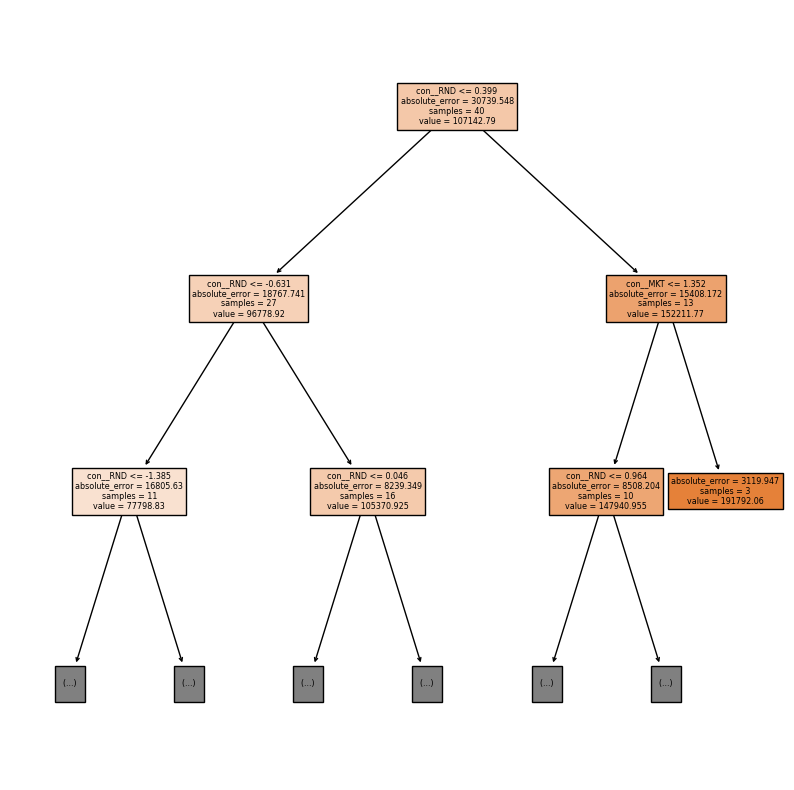

In [61]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(10,10))
plot_tree(best_dtr, max_depth=2, feature_names=xtrain.columns, filled=True)
plt.show()